## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5' #dataset-compression
TRANSFORM = 'fft-male' #transform-group
CHANNEL = ''
COEFF_TYPE = 'complex' #['complex', 'real', 'imaginary']

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_fft_1e5_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5\\fft\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "raw-transformed-data", "subsample-data", COEFF_TYPE, f'{FULL_DATA_NAME}.pickle'))
#group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data","raw-transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
group_data_map.keys()
group_total_samples = {}
for i in group_data_map:
    group_total_samples[i] = len(group_data_map[i])

In [8]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map

KeyboardInterrupt: 

Running 12760 CDFs


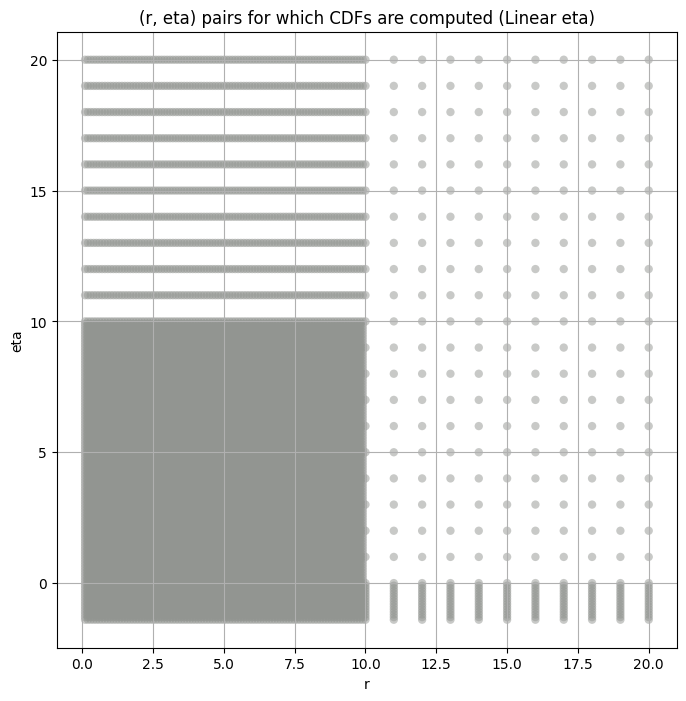

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [57]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [58]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [60]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,4.169329e+14,3.187509e+14,5.354746e+14,5.398810,1.884245,8.783362,720.0
5,8.745052e+14,7.474632e+14,1.013377e+15,22.821087,18.738922,27.180742,7200.0
8,1.869221e+14,1.600070e+14,2.170753e+14,33.693208,24.327487,43.683258,13680.0
11,1.394615e+13,1.143433e+13,1.842871e+13,93.405489,13.585954,275.495476,28080.0
14,5.587727e+14,5.210669e+14,5.991010e+14,5.337993,3.860132,7.504724,56160.0
17,4.520915e+14,4.294030e+14,4.760405e+14,2.003496,1.428311,3.060648,450720.0
20,1.933728e+13,1.820628e+13,2.062081e+13,3.771140,2.082114,13.561583,901440.0
23,5.947322e+12,5.549842e+12,6.415372e+12,5.820011,3.135095,17.554243,7211520.0
26,2.959653e+11,2.780049e+11,3.151043e+11,3.963177,2.807603,6.129431,3605760.0


## Initial Grid Search and Hypothesis Test Plots

In [61]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [62]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,4.169329e+14,4.169329e+14,4.242251e+14,4.395237e+14,4.510401e+14,4.429224e+14,4.639490e+14,4.830626e+14,4.150510e+14,5.594528e+14,2.290902e+14,NaN
5,8.745052e+14,8.745052e+14,8.782799e+14,8.792292e+14,8.717862e+14,8.757414e+14,8.762721e+14,8.878829e+14,8.940052e+14,8.993483e+14,8.969064e+14,8.586154e+14
8,1.869221e+14,1.869221e+14,1.873494e+14,1.877297e+14,1.883066e+14,1.887226e+14,1.897069e+14,1.905200e+14,1.913875e+14,1.925735e+14,1.937340e+14,1.962613e+14
11,1.394615e+13,1.394615e+13,1.396207e+13,1.397303e+13,1.397937e+13,1.399575e+13,1.403094e+13,1.405720e+13,1.408085e+13,1.409243e+13,1.412029e+13,1.418267e+13
14,5.587727e+14,5.587727e+14,5.582174e+14,5.581351e+14,5.579550e+14,5.577086e+14,5.563476e+14,5.551649e+14,5.535465e+14,5.486847e+14,5.485235e+14,5.507364e+14
17,4.520915e+14,4.520915e+14,4.520933e+14,4.520644e+14,4.520191e+14,4.519898e+14,4.518939e+14,4.519184e+14,4.519357e+14,4.519037e+14,4.519423e+14,4.519924e+14
20,1.933728e+13,1.933728e+13,1.933716e+13,1.933679e+13,1.933675e+13,1.933712e+13,1.933673e+13,1.933623e+13,1.933596e+13,1.933592e+13,1.933630e+13,1.933749e+13
23,5.947322e+12,5.947322e+12,5.947301e+12,5.947291e+12,5.947158e+12,5.947011e+12,5.946985e+12,5.946974e+12,5.946945e+12,5.946934e+12,5.946907e+12,5.946485e+12
26,2.959653e+11,2.959653e+11,2.959633e+11,2.959630e+11,2.959630e+11,2.959644e+11,2.959687e+11,2.959647e+11,2.959546e+11,2.959523e+11,2.959518e+11,2.959423e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.5000003711116757 416932946190793.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.5000003711116757 424225105519440.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.5000003711116757 439523703872071.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.5000003711116757 451040111247695.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.5000003711116757 442922436069544.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.5000003711116757 463948969719337.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.5000003711116757 483062594076663.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.5000003711116757 415050974810149.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.5000003711116757 559452838002208.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.5000003711116757 229090187997559.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 720, Without approximation : 720.0


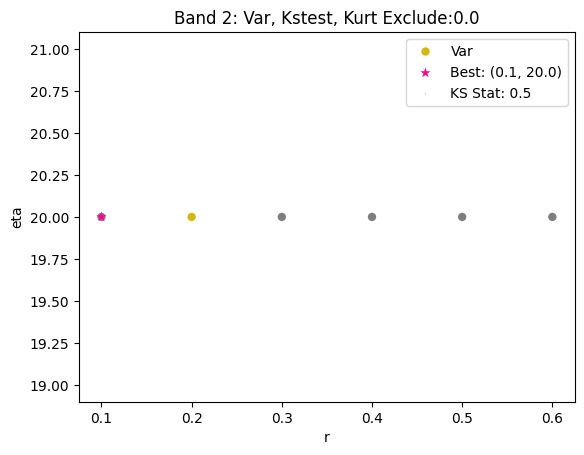

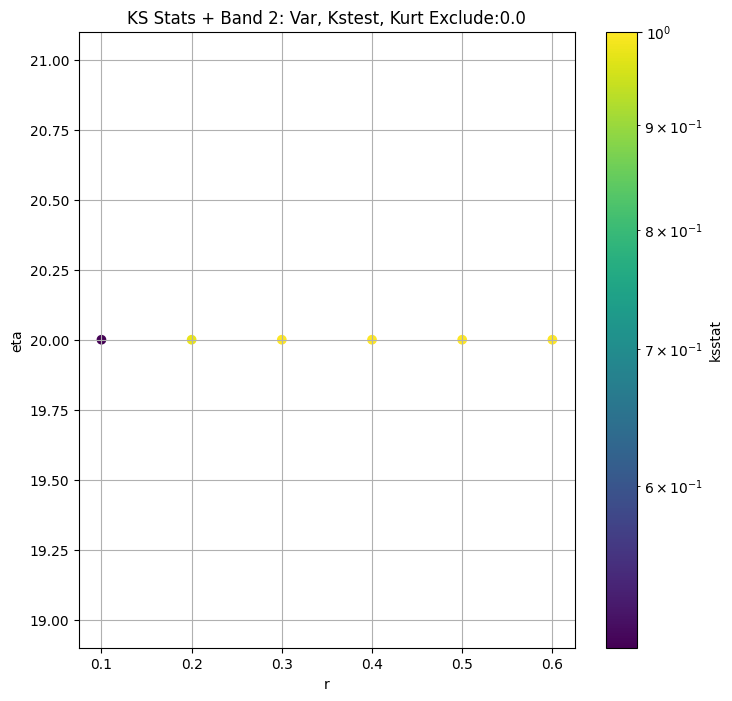

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.5000000110539043 874505154387031.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.5000000110539043 878279925072737.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.5000000110539043 879229203189422.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.5000000110539043 871786238098178.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.5000000110539043 875741415713267.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.5000000110539043 876272138791068.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.5000000110539043 887882850185584.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.5000000110539043 894005238705693.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.5000000110539043 899348314274695.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.5000000110539043 896906426676373.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.5000000110539043 858615357605792.5
Number of samples: 7200, Without approximation : 7200.0


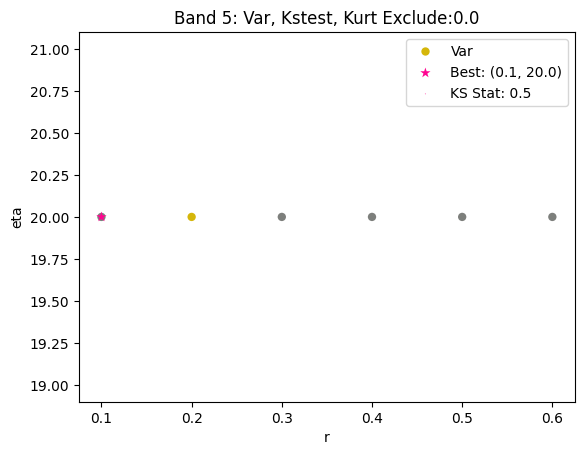

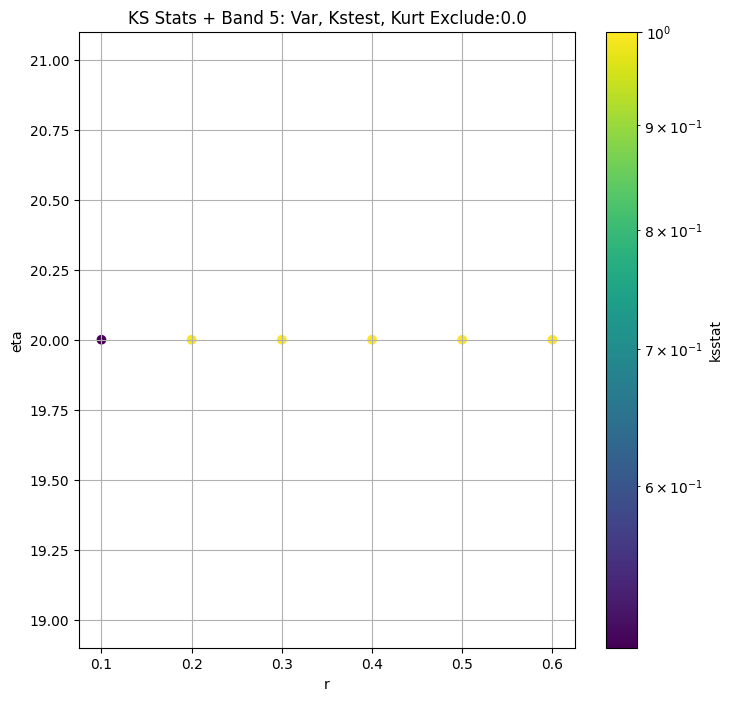

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.4999999999441206 186922118082488.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.4999999999441206 187349427753576.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.4999999999441206 187729732506414.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.4999999999441206 188306578042592.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.4999999999441206 188722607135706.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.4999999999441206 189706884909871.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.4999999999441206 190519953267360.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.4999999999441206 191387470633981.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.4999999999441206 192573520627363.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.4999999999441206 193733963359333.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.4999999999441206 196261332461030.56
Number of samples: 13680, Without approximation : 13680.0


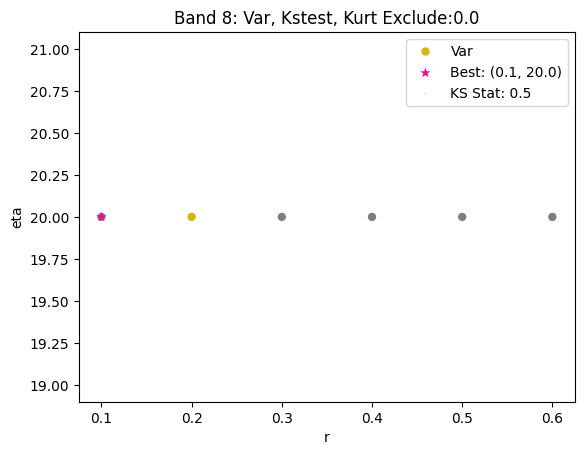

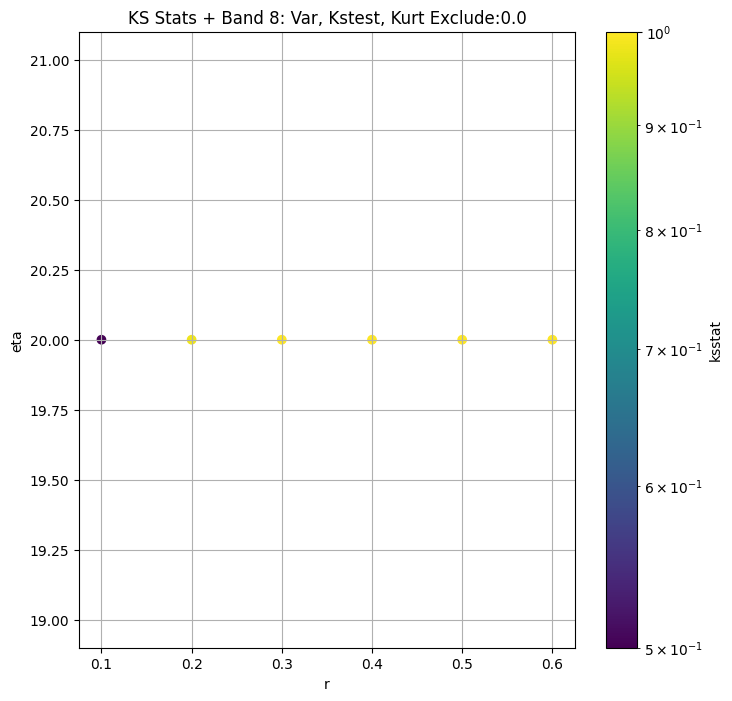

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.499999998843559 13946151561167.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.499999998843559 13962073460614.275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.499999998843559 13973031942541.871


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.499999998843559 13979369227681.627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.499999998843559 13995752222114.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.499999998843559 14030939135070.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.499999998843559 14057204057573.861


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.499999998843559 14080847472478.965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.499999998843559 14092429627582.018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.499999998843559 14120293899406.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.499999998843559 14182670487575.02
Number of samples: 28080, Without approximation : 28080.0


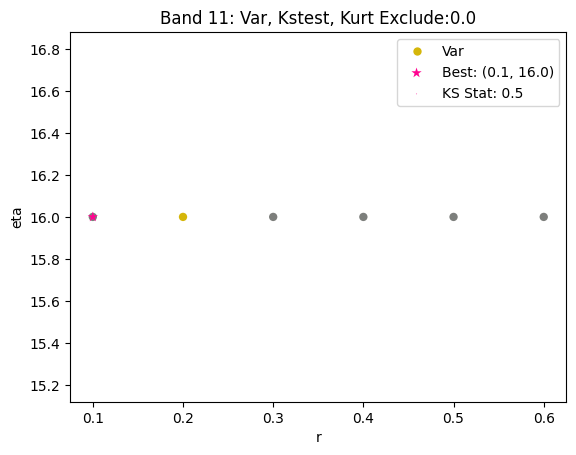

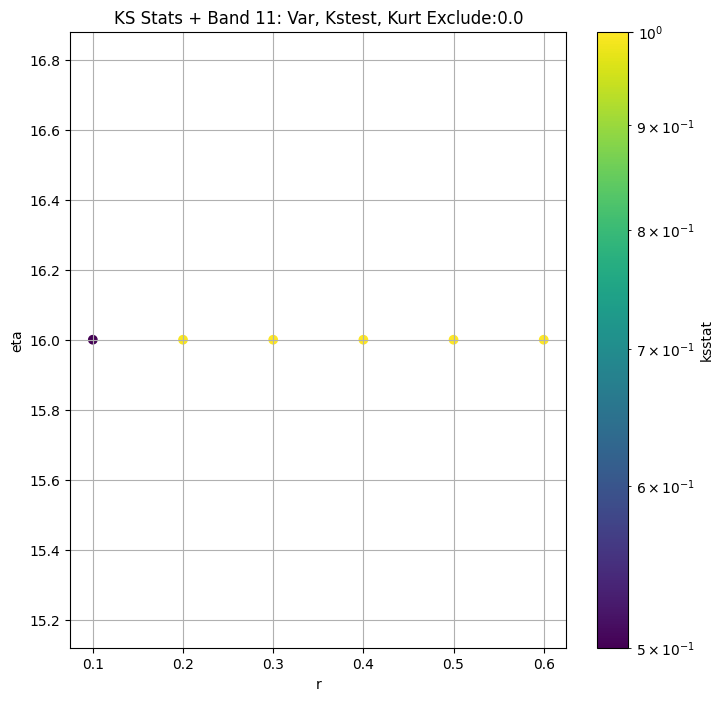

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.49999964654007656 558772698213683.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.49999964654007656 558217363462057.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.49999964654007656 558135066020567.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.49999964654007656 557955014423746.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.49999964654007656 557708627379687.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.49999964654007656 556347646599173.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.49999964654007656 555164902098235.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.49999964654007656 553546480325936.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.49999964654007656 548684660171333.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.49999964654007656 548523546697655.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.49999964654007656 550736413102921.4
Number of samples: 56160, Without approximation : 56160.0


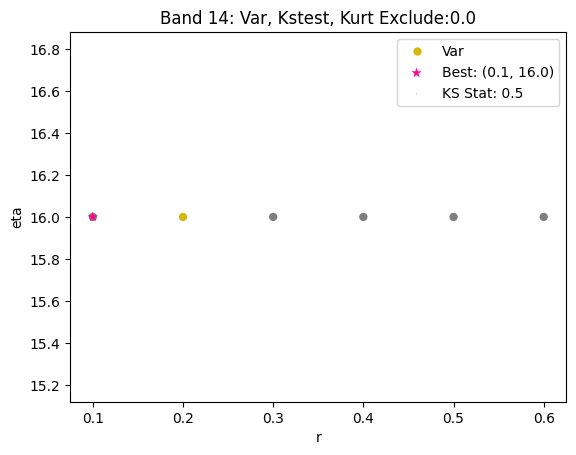

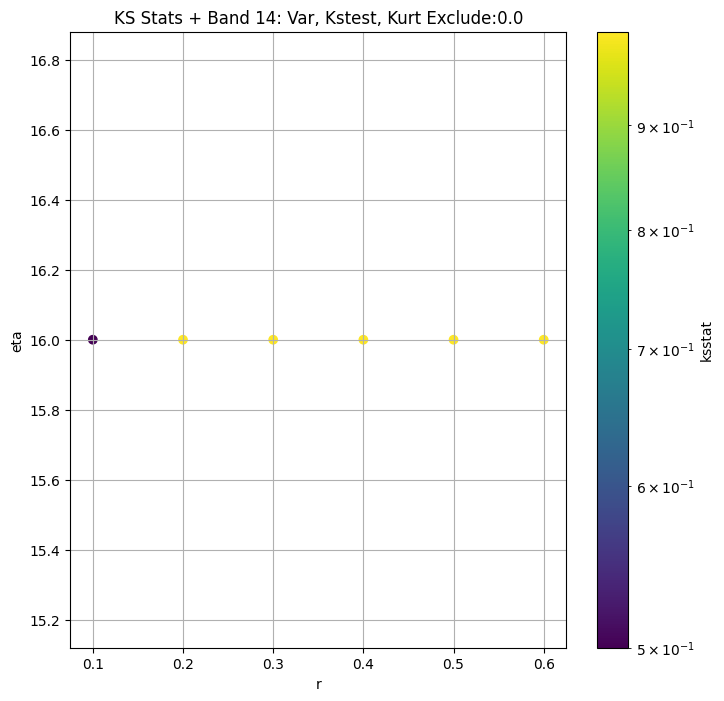

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.49999999999911926 452091526355931.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.49999999999911926 452093297884787.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.49999999999911926 452064367400305.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.49999999999911926 452019077064789.44


  0%|          | 0/12760 [00:00<?, ?it/s]

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


100%|██████████| 9/9 [00:00<00:00, 806.89it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.027669609635848413, var: 160110.40625


100%|██████████| 9/9 [00:00<00:00, 926.21it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.026320765228824983, var: 162222.5625


100%|██████████| 9/9 [00:00<00:00, 1197.46it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.024882507661585618, var: 164473.203125


100%|██████████| 9/9 [00:00<00:00, 843.66it/s]


Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.023321938303791978, var: 167002.609375


100%|██████████| 9/9 [00:00<00:00, 820.57it/s]

Finding Minimum after computing 9 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.02137939222871399, var: 170305.0
Number of samples: 19544, Without approximation : 19544.0


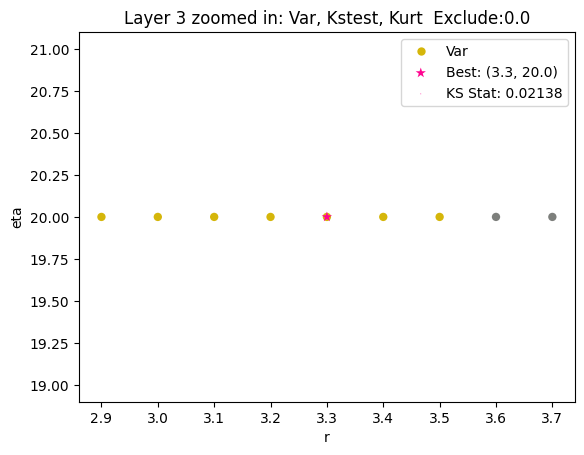

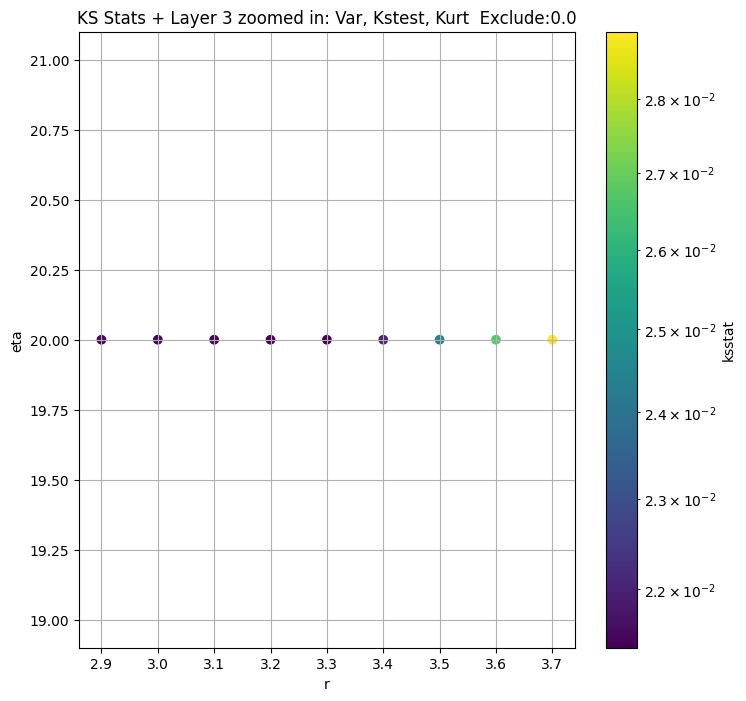

Layer 4


100%|██████████| 36/36 [00:00<00:00, 165.95it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.026225315315881903, var: 264230.1875


100%|██████████| 36/36 [00:00<00:00, 262.79it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.025807807751706935, var: 265186.59375


100%|██████████| 36/36 [00:00<00:00, 264.31it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.02534365744232711, var: 266254.625


100%|██████████| 36/36 [00:00<00:00, 246.37it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.024804264230758155, var: 267502.15625


100%|██████████| 36/36 [00:00<00:00, 265.70it/s]


Finding Minimum after computing 36 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.02401096317428736, var: 269349.46875
Number of samples: 100000, Without approximation : 177766.0


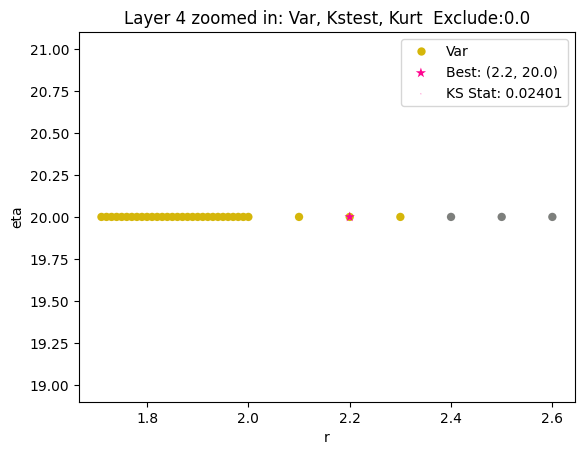

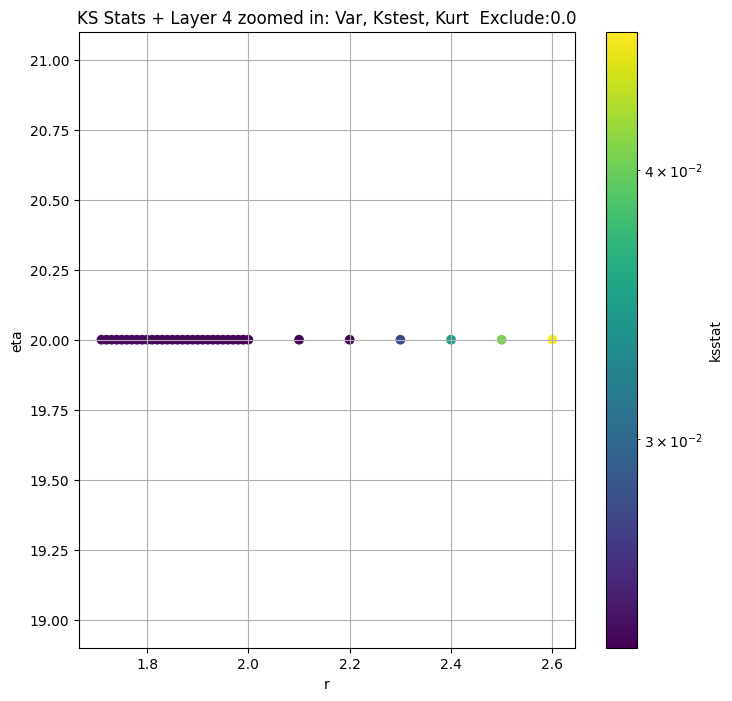

Layer 5


100%|██████████| 1233/1233 [00:05<00:00, 235.86it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.0030982431101056473, var: 84706.25


100%|██████████| 1233/1233 [00:04<00:00, 275.07it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.0029870133382923214, var: 85362.4140625


100%|██████████| 1233/1233 [00:04<00:00, 254.35it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.0029171241633815237, var: 86059.96875


100%|██████████| 1233/1233 [00:04<00:00, 262.73it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.002831574196401787, var: 86815.734375


100%|██████████| 1233/1233 [00:04<00:00, 264.35it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.0029287396344158667, var: 87637.5703125


100%|██████████| 1233/1233 [00:04<00:00, 271.87it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0030402995856273485, var: 88552.34375


100%|██████████| 1233/1233 [00:04<00:00, 268.78it/s]


Finding Minimum after computing 1233 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.0030402995856273485, var: 89765.7890625
Number of samples: 100000, Without approximation : 820632.0


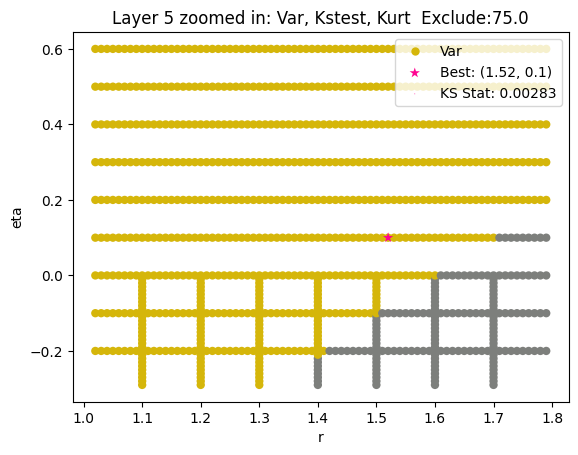

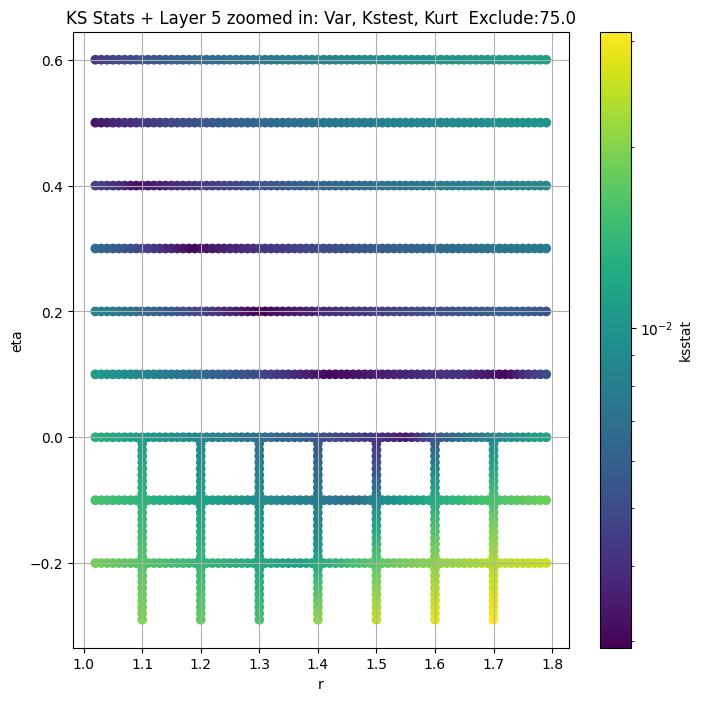

Layer 6


100%|██████████| 1701/1701 [00:06<00:00, 262.66it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.0049968166395089955, var: 23081.96484375


100%|██████████| 1701/1701 [00:06<00:00, 270.76it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.004742539693273096, var: 23315.27734375


100%|██████████| 1701/1701 [00:06<00:00, 274.16it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004496436293315587, var: 23557.51171875


100%|██████████| 1701/1701 [00:06<00:00, 268.16it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.004250026746565716, var: 23809.3671875


100%|██████████| 1701/1701 [00:06<00:00, 265.83it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.004020727353340145, var: 24072.08203125


100%|██████████| 1701/1701 [00:06<00:00, 281.45it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.003854267368488151, var: 24346.26953125


100%|██████████| 1701/1701 [00:06<00:00, 267.56it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.0038445721726027976, var: 24632.0859375


100%|██████████| 1701/1701 [00:06<00:00, 281.88it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.0039960475345699464, var: 24931.1171875


100%|██████████| 1701/1701 [00:06<00:00, 274.44it/s]


Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.004261843572176738, var: 25245.236328125
Number of samples: 100000, Without approximation : 3670424.0


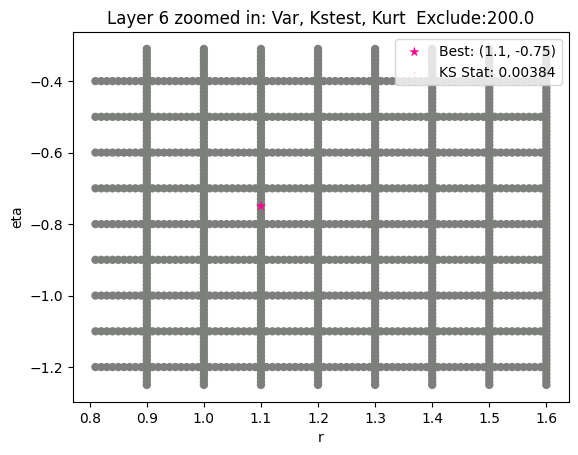

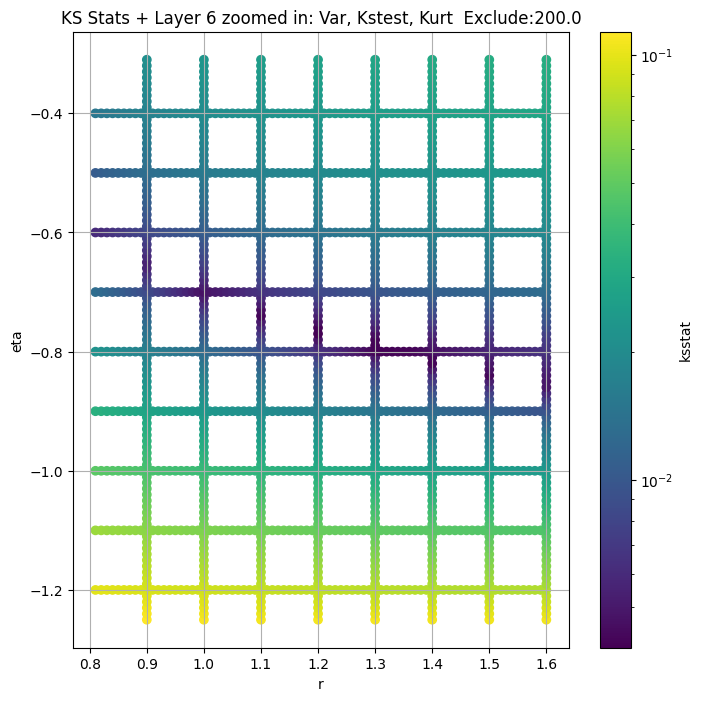

Layer 7


100%|██████████| 1900/1900 [00:06<00:00, 273.91it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.005248236210511797, var: 5119.251953125


100%|██████████| 1900/1900 [00:06<00:00, 276.08it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.005007382217421141, var: 5180.8779296875


100%|██████████| 1900/1900 [00:06<00:00, 274.87it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.004722346897830909, var: 5244.9736328125


100%|██████████| 1900/1900 [00:08<00:00, 221.44it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.004483789146872197, var: 5311.80615234375


100%|██████████| 1900/1900 [00:07<00:00, 246.62it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.004530310214850952, var: 5381.8564453125


100%|██████████| 1900/1900 [00:07<00:00, 267.90it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.004668053856230148, var: 5455.62841796875


100%|██████████| 1900/1900 [00:06<00:00, 273.22it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.005061590489003676, var: 5533.830078125


100%|██████████| 1900/1900 [00:06<00:00, 278.39it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.004506124307351894, var: 5617.515625


100%|██████████| 1900/1900 [00:06<00:00, 276.28it/s]


Finding Minimum after computing 1900 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.005102929312563564, var: 5708.3818359375
Number of samples: 100000, Without approximation : 15384514.0


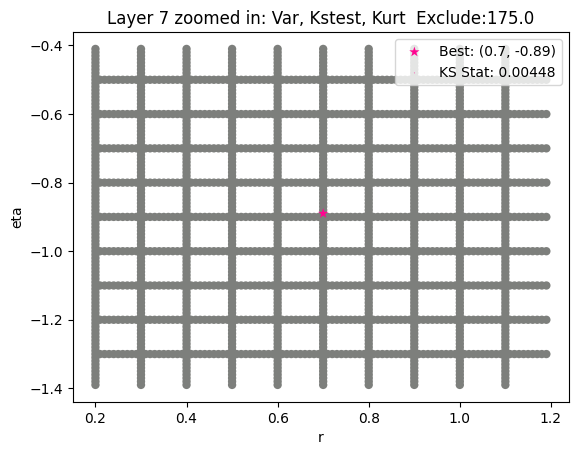

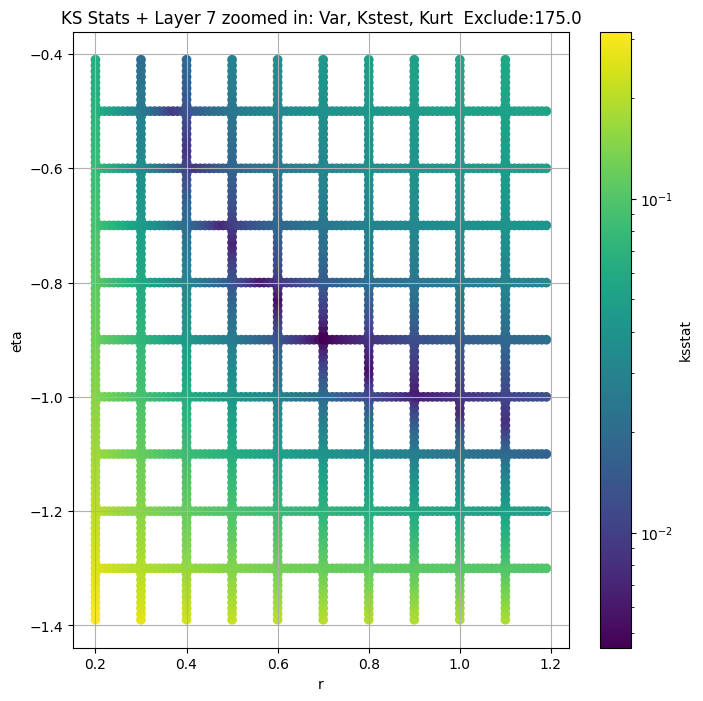

Layer 8


100%|██████████| 1512/1512 [00:05<00:00, 261.00it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.004894243919149166, var: 651.7974853515625


100%|██████████| 1512/1512 [00:06<00:00, 245.86it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.004536077033868935, var: 662.3878173828125


100%|██████████| 1512/1512 [00:05<00:00, 267.59it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.0041585282158440595, var: 673.703857421875


100%|██████████| 1512/1512 [00:05<00:00, 279.89it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.0037356738333563545, var: 685.930908203125


100%|██████████| 1512/1512 [00:05<00:00, 284.86it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.003414094824867653, var: 699.3534545898438


100%|██████████| 1512/1512 [00:05<00:00, 267.45it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.00330005017040369, var: 714.530029296875


100%|██████████| 1512/1512 [00:05<00:00, 278.65it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.002816803306889437, var: 732.8817749023438


100%|██████████| 1512/1512 [00:05<00:00, 275.27it/s]


Finding Minimum after computing 1512 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.003263948192618271, var: 762.61376953125
Number of samples: 100000, Without approximation : 62976002.0


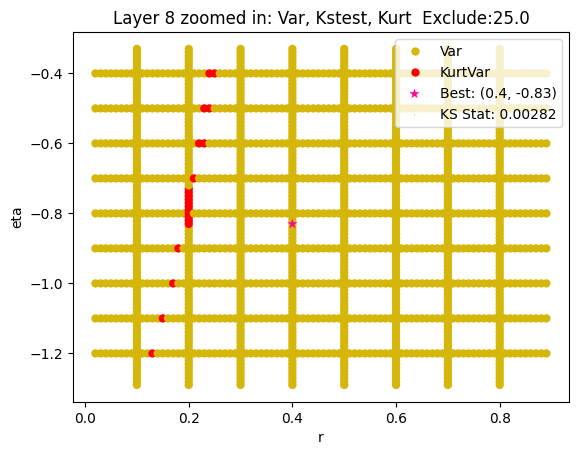

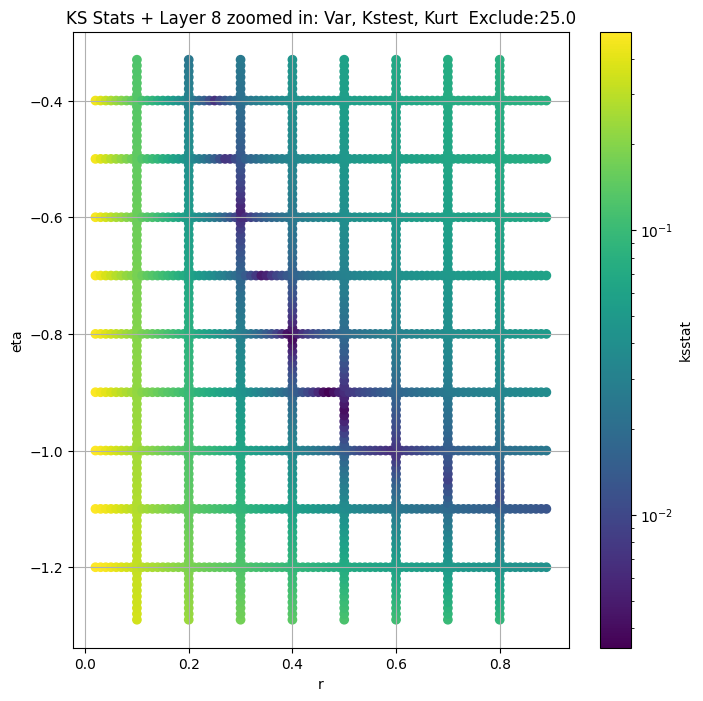

Layer 9


100%|██████████| 1188/1188 [00:04<00:00, 268.32it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.003802471384727363, var: 59.83527755737305


100%|██████████| 1188/1188 [00:04<00:00, 265.00it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.0034705488648871796, var: 61.415382385253906


100%|██████████| 1188/1188 [00:04<00:00, 276.88it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.0030240661858493834, var: 63.206809997558594


100%|██████████| 1188/1188 [00:04<00:00, 275.70it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.0030026235039450344, var: 65.31522369384766


100%|██████████| 1188/1188 [00:04<00:00, 254.93it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.0023778412284107264, var: 68.01790618896484


100%|██████████| 1188/1188 [00:05<00:00, 231.00it/s]


Finding Minimum after computing 1188 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.001953726503903075, var: 72.97090911865234
Number of samples: 100000, Without approximation : 254776200.0


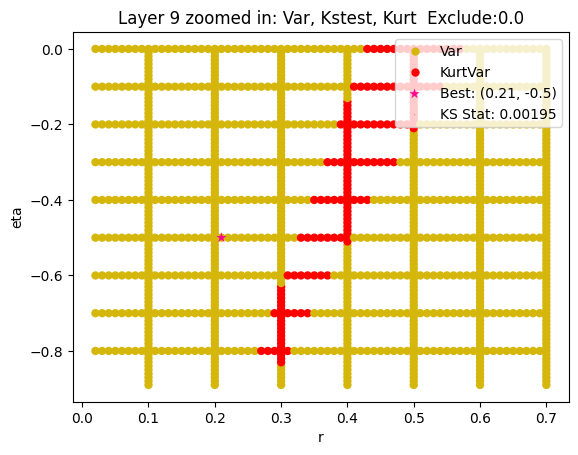

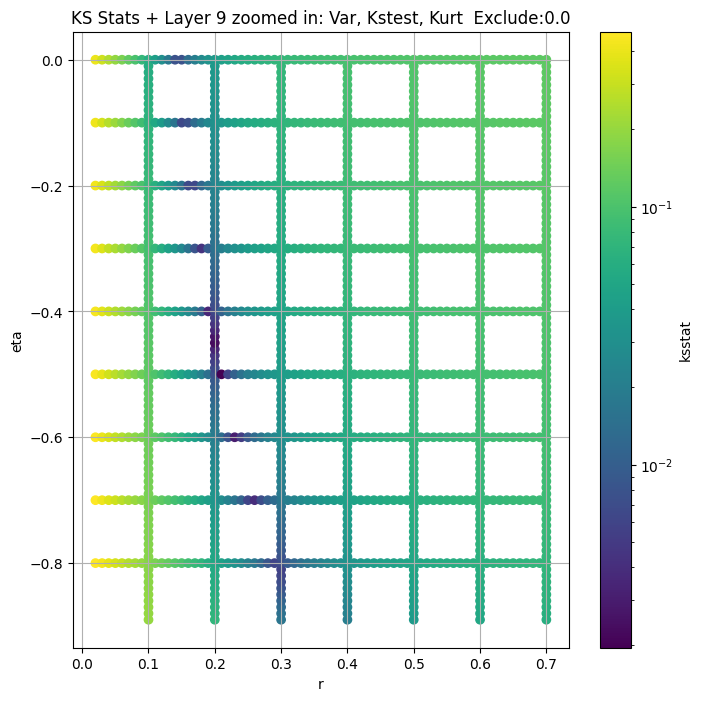

Cannot compute pval with ksstat : 1.0, n : 0.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-1
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0,0.021379,3.3,20.0,98104.240306,0.0,170305.000000,0.009706,0.021379,3.30,20.00,98104.240306,0.0,4122
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0,0.024011,2.2,20.0,96788.580679,0.0,269349.470000,0.003220,0.024011,2.20,20.00,96788.580679,0.0,3123
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0,0.002929,1.3,0.2,75896.227113,50.0,86815.734375,0.001499,0.002832,1.52,0.10,92684.255325,75.0,230802
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0,0.004154,1.3,-0.8,44293.576994,250.0,24632.085938,0.000709,0.003845,1.10,-0.75,36644.981469,200.0,129037
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0,0.004530,0.7,-0.9,5144.353461,150.0,5311.806152,0.000346,0.004484,0.70,-0.89,4975.299048,175.0,90142
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0,0.003824,0.4,-0.8,77.579113,75.0,732.881775,0.000171,0.002817,0.40,-0.83,88.266105,25.0,246000
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0,0.003494,0.2,-0.4,0.003142,25.0,72.970909,0.000085,0.001954,0.21,-0.50,0.009796,0.0,497609


In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

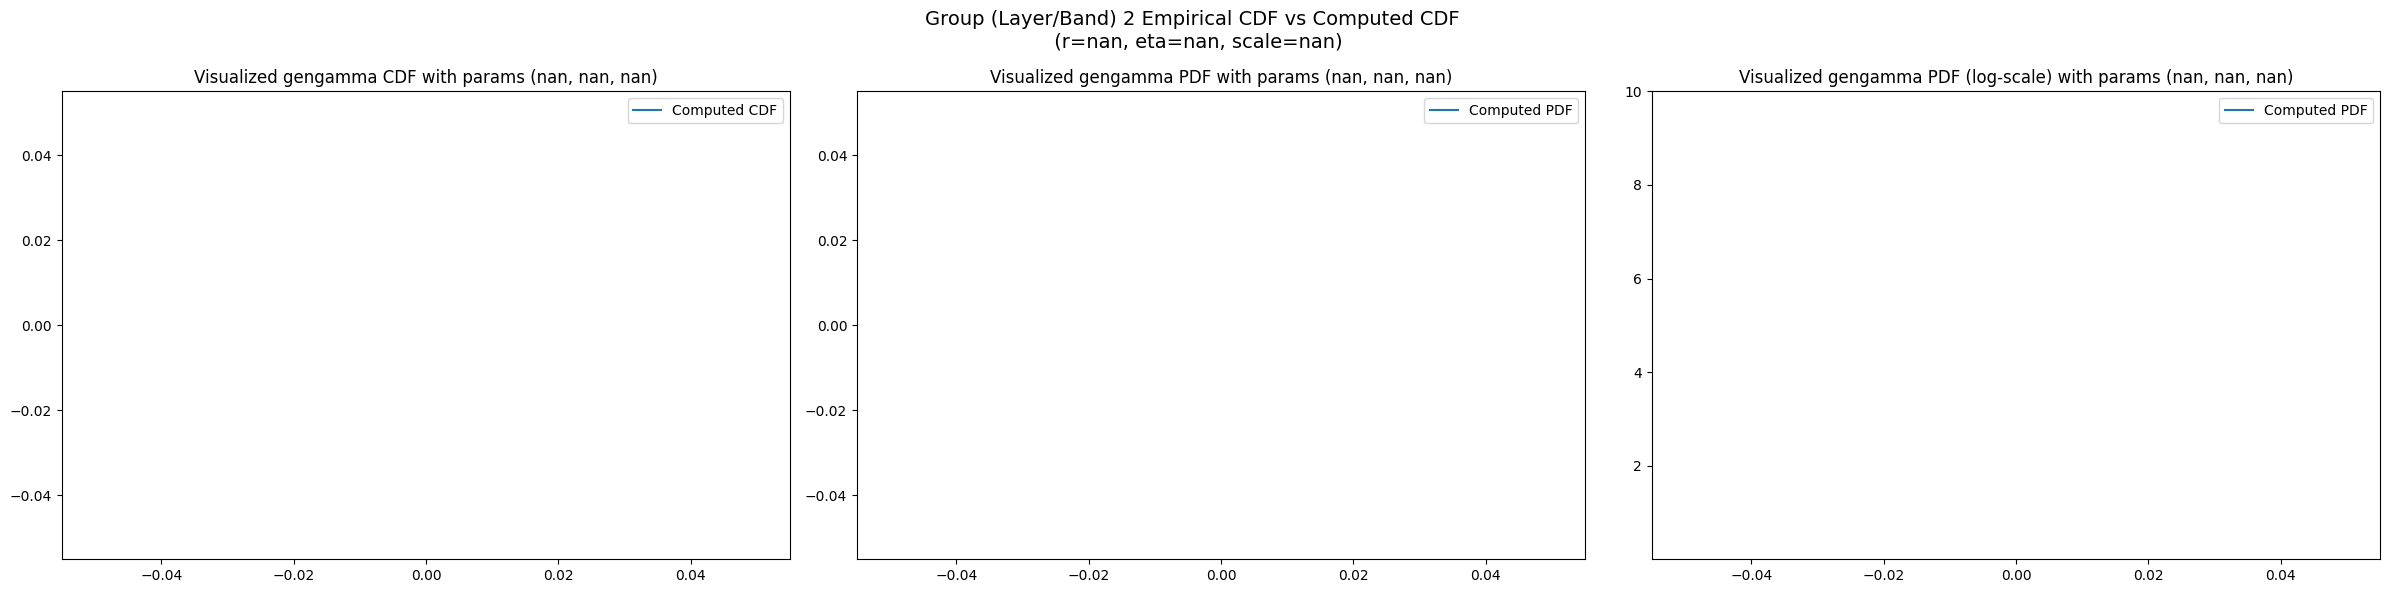

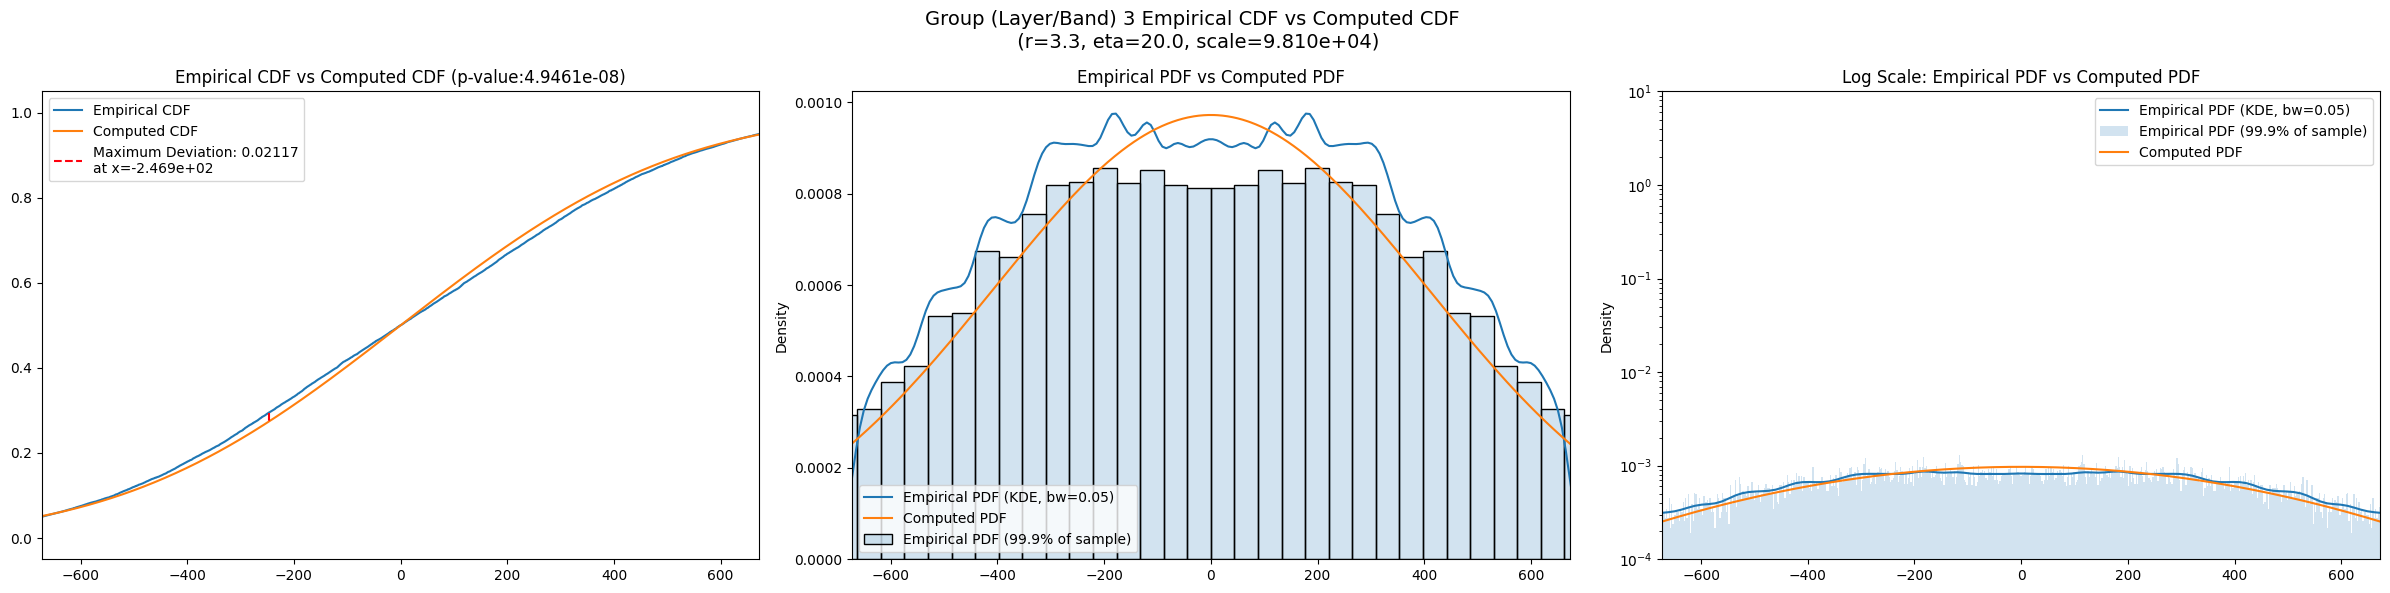

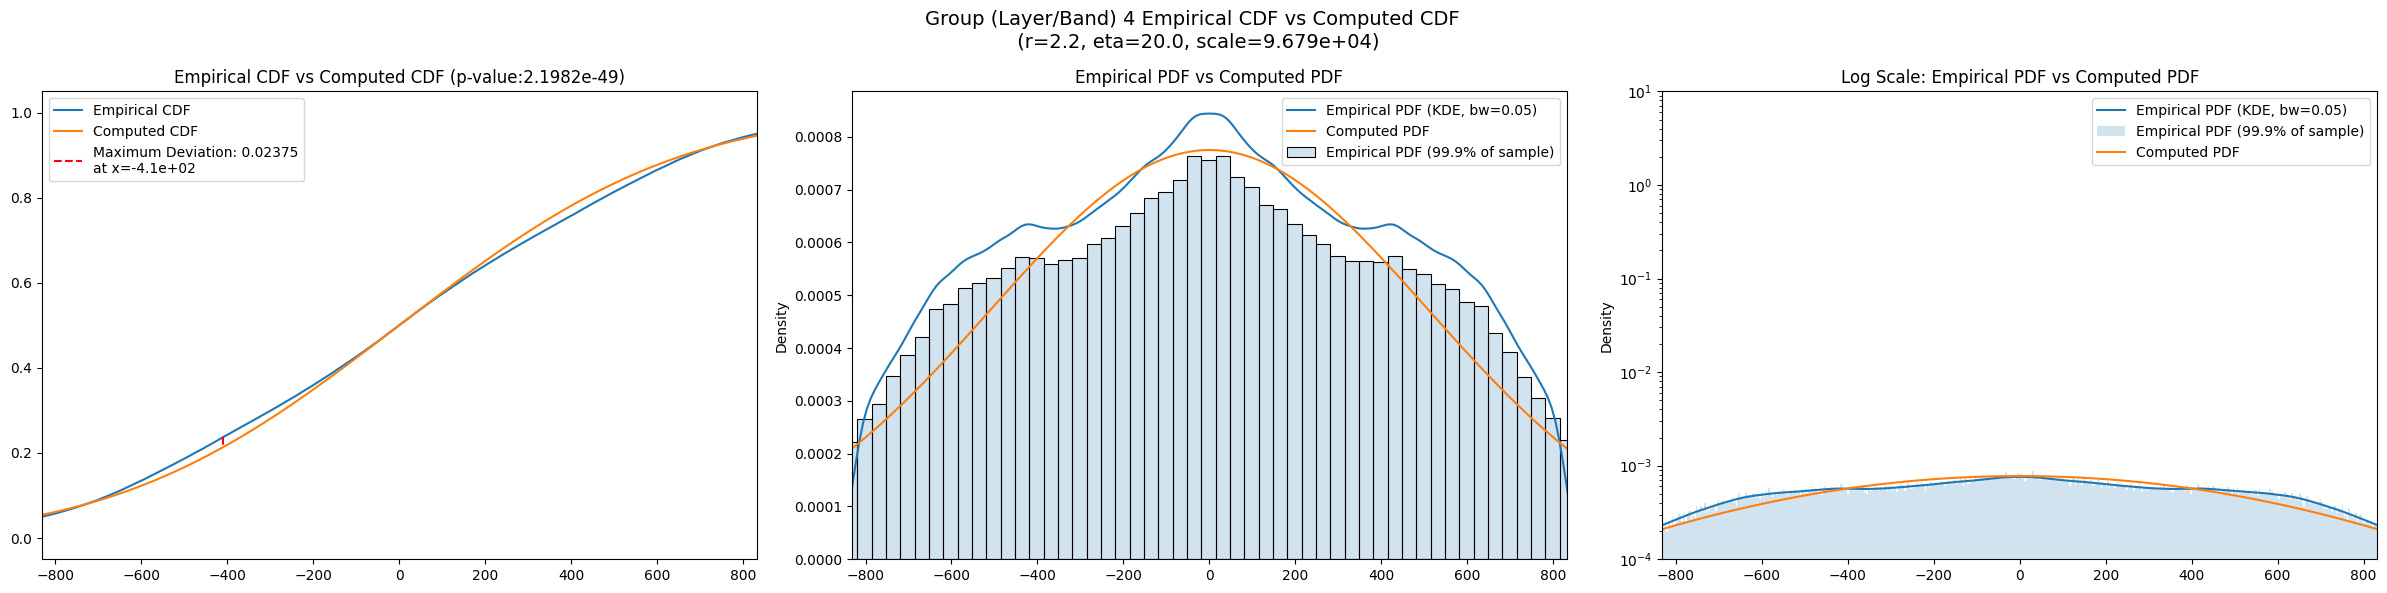

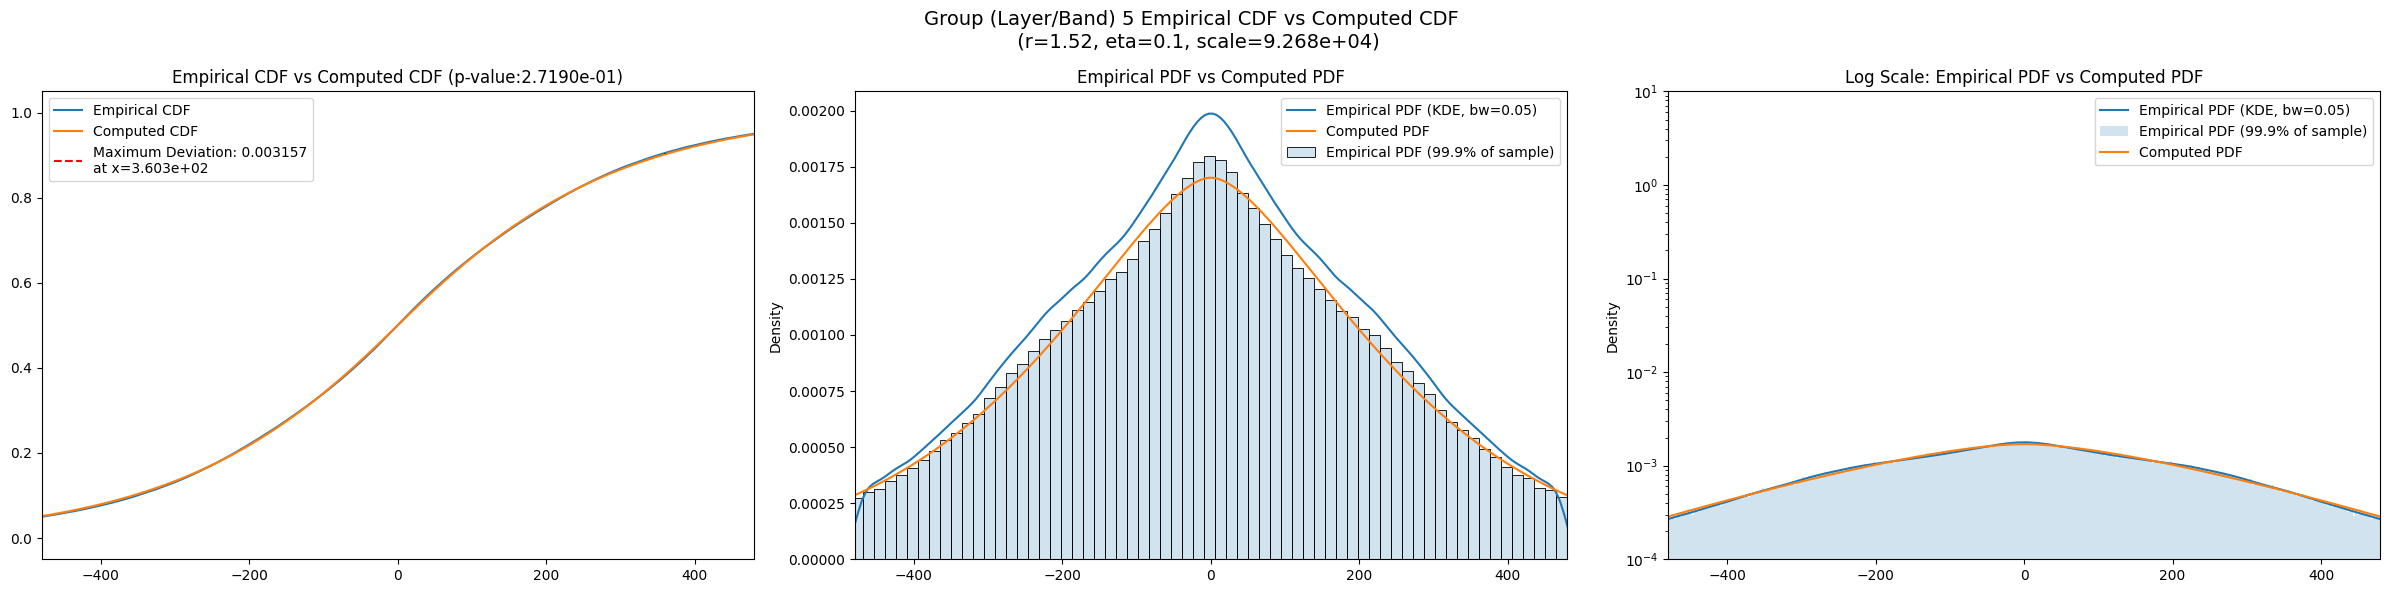

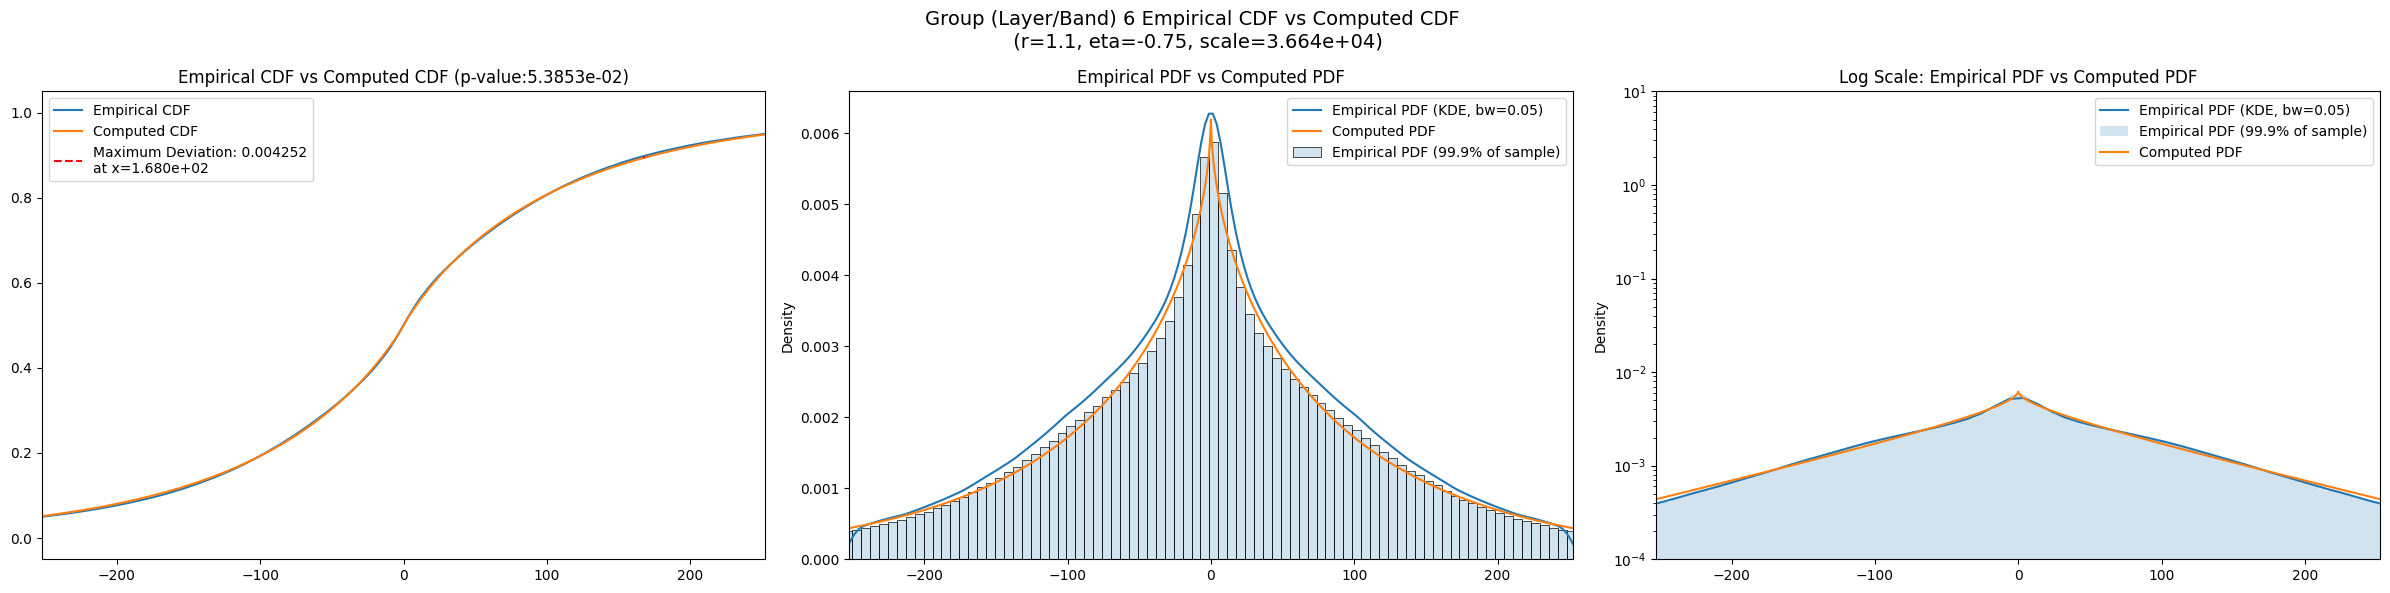

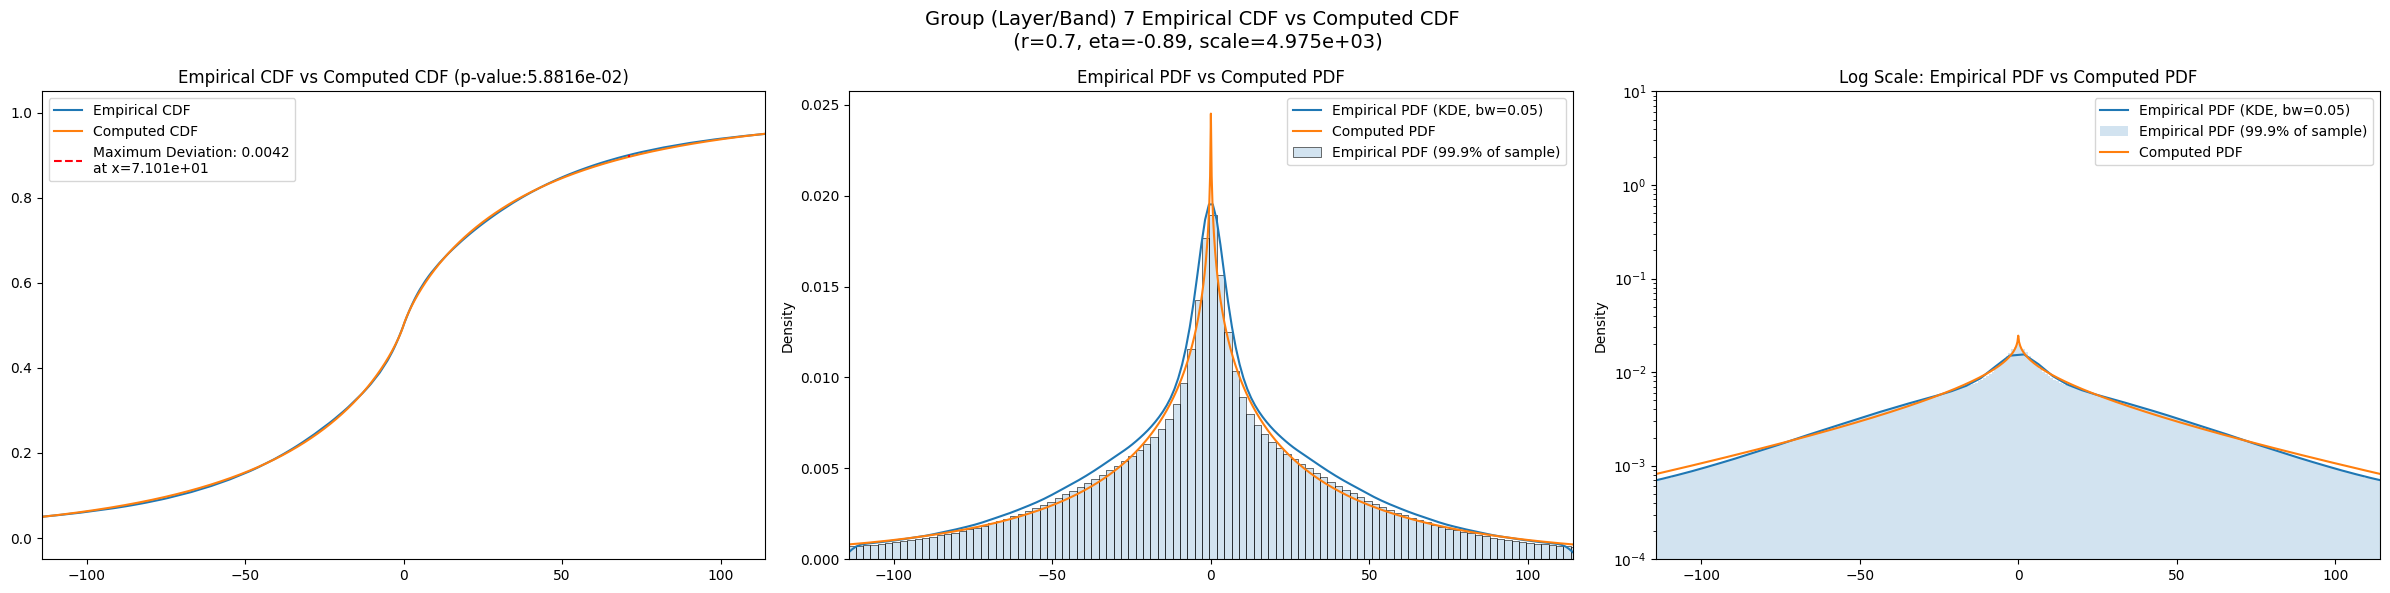

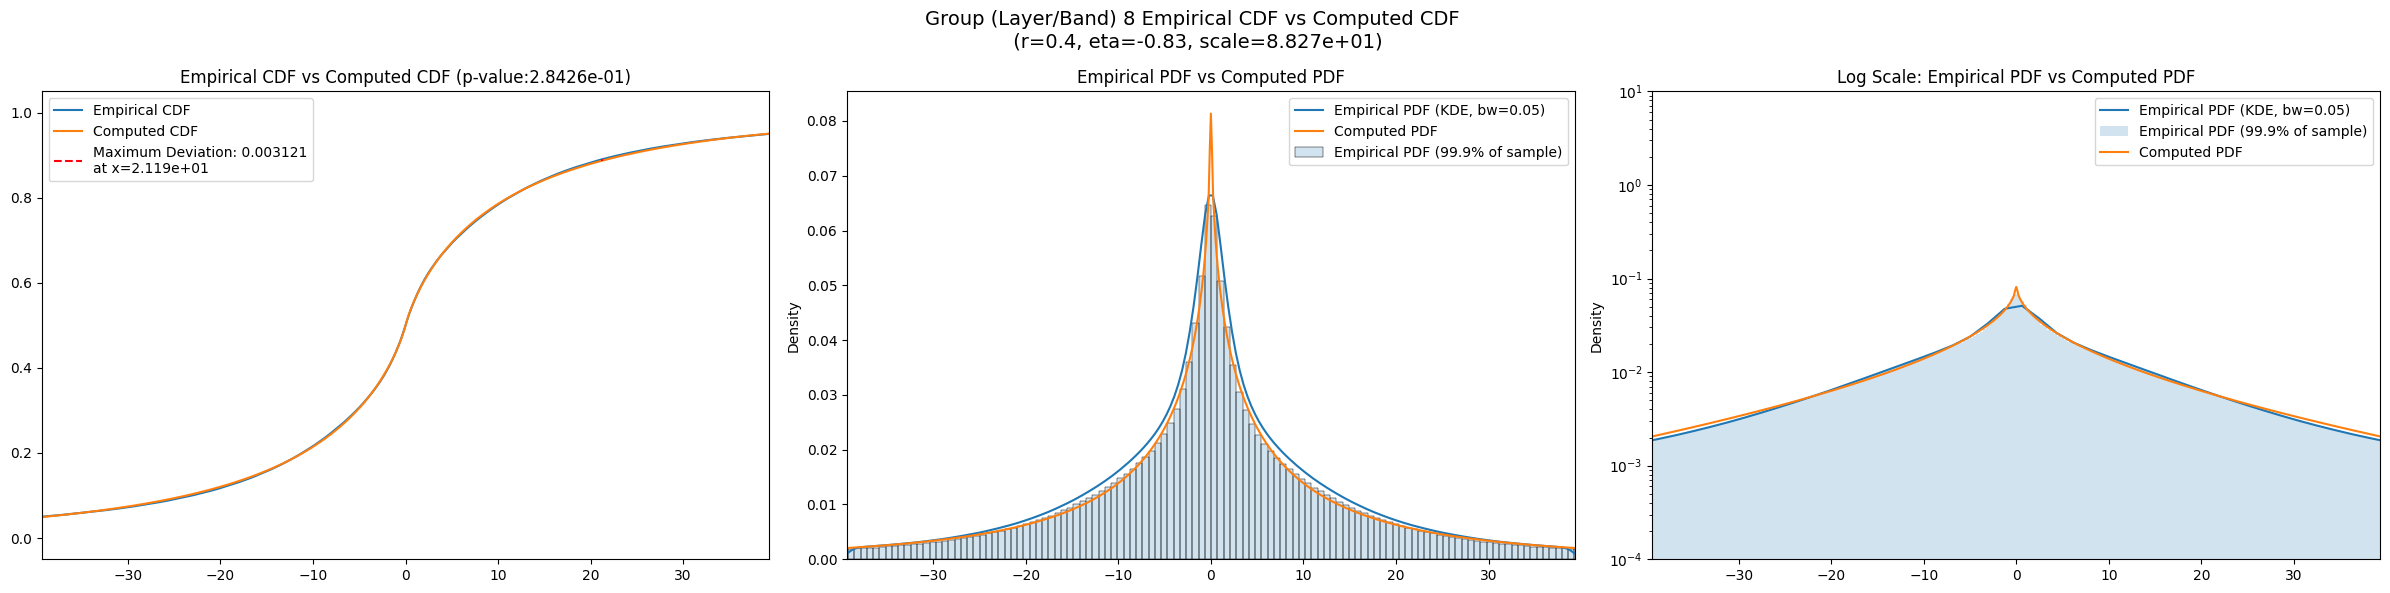

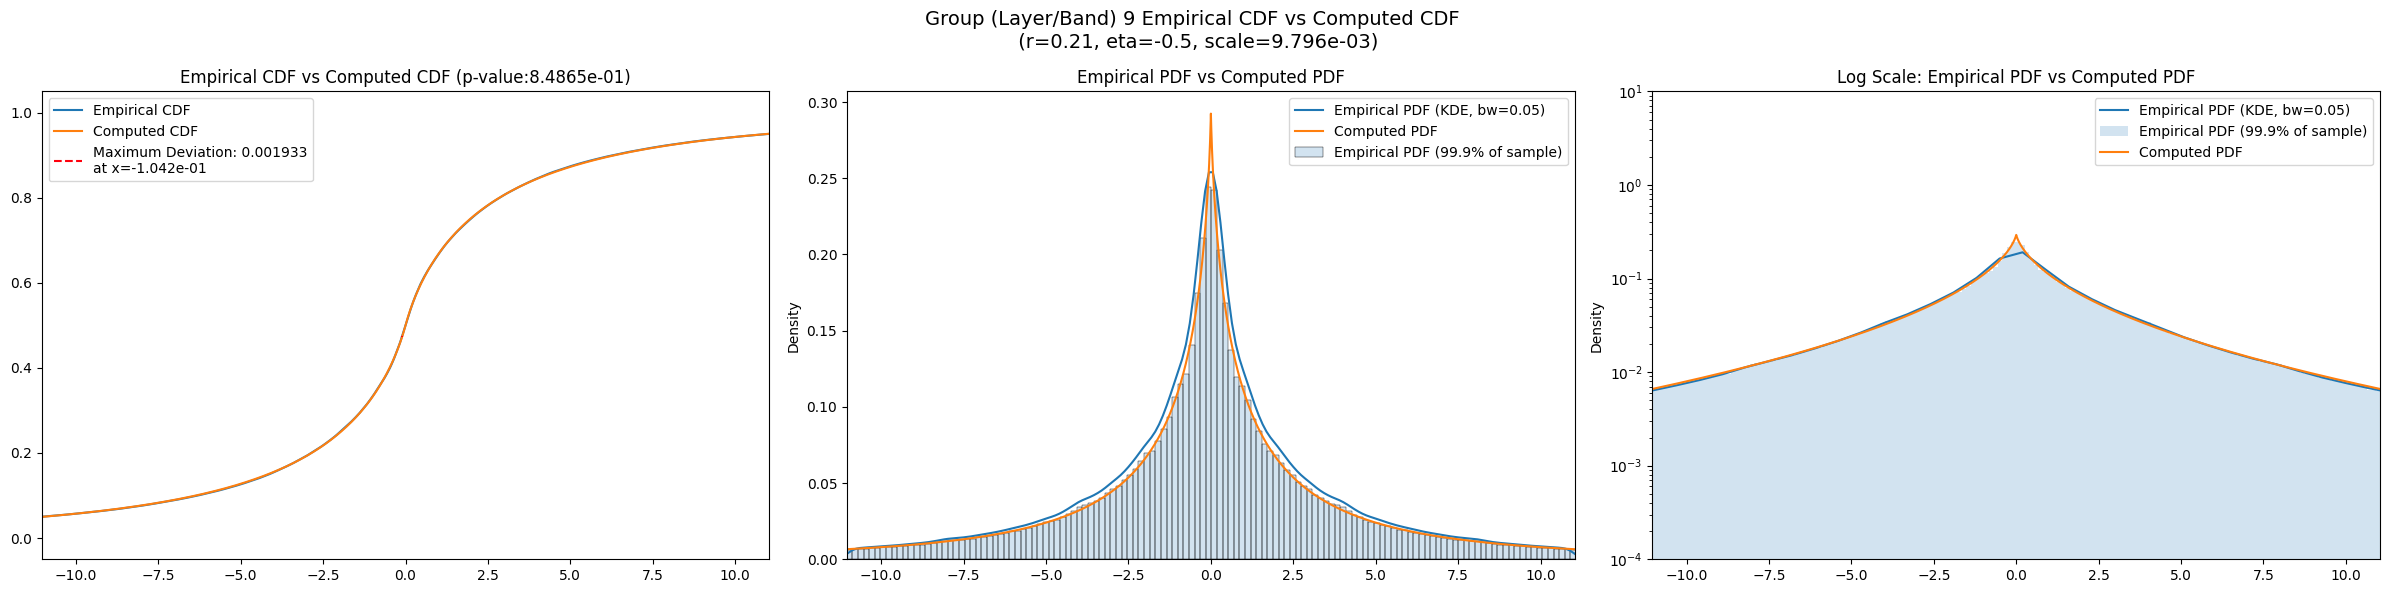

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,170305.00000,164909.47000,175804.86000,-0.464481,-0.540597,-0.383066,19544.0,0.021379,3.3,20.0,...,433.5290,0.012450,4.634060e-03,379.0590,0.040592,2.031160e-28,309.68900,0.041724,5.308450e-30,3.426982e-08
4,269349.47000,260584.97000,278149.56000,-0.415785,-0.529190,-0.262445,177766.0,0.024011,2.2,20.0,...,542.6020,0.012403,3.513010e-24,466.3760,0.036658,5.444050e-208,386.69300,0.040586,7.218110e-255,1.836076e-89
5,89765.79000,85311.62000,94332.43000,1.816636,1.392810,2.345721,820632.0,0.002929,1.3,0.2,...,268.1650,0.014941,1.449820e-159,233.9960,0.014092,5.538000e-142,192.57900,0.017854,1.200100e-227,3.847422e-06
6,27723.13700,25801.26000,29725.77000,5.616802,4.711250,6.687731,3670424.0,0.004154,1.3,-0.8,...,118.2890,0.034389,0.000000e+00,101.1830,0.009509,1.052680e-288,83.88910,0.015877,0.000000e+00,1.505241e-47
7,5939.07570,5490.06700,6403.12160,7.063244,6.073430,8.459994,15384514.0,0.004530,0.7,-0.9,...,45.5471,0.048245,0.000000e+00,39.0462,0.023592,0.000000e+00,31.24510,0.027386,0.000000e+00,4.453877e-269
8,762.61380,692.95807,839.26680,11.767686,8.738594,18.807537,62976002.0,0.003824,0.4,-0.8,...,14.0442,0.056573,0.000000e+00,12.1815,0.031154,0.000000e+00,9.52024,0.032610,0.000000e+00,0.000000e+00
9,72.97091,64.01033,83.24985,23.847502,14.821177,42.472622,254776200.0,0.003494,0.2,-0.4,...,3.7067,0.061274,0.000000e+00,3.2468,0.034819,0.000000e+00,2.51904,0.035631,0.000000e+00,0.000000e+00


## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,1.000000,NaN,1.000000,NaN,NaN,NaN
3,0.021379,0.009706,0.021379,0.012450,0.040592,0.041724
4,0.024011,0.003220,0.024011,0.012403,0.036658,0.040586
5,0.002929,0.001499,0.002832,0.014941,0.014092,0.017854
6,0.004154,0.000709,0.003845,0.034389,0.009509,0.015877
7,0.004530,0.000346,0.004484,0.048245,0.023592,0.027386
8,0.003824,0.000171,0.002817,0.056573,0.031154,0.032610
9,0.003494,0.000085,0.001954,0.061274,0.034819,0.035631


In [ ]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,NaN,1.000000,NaN,NaN,NaN,NaN
3,170305.000000,0.021379,3.30,20.00,98104.240306,0.0
4,269349.470000,0.024011,2.20,20.00,96788.580679,0.0
5,86815.734375,0.002832,1.52,0.10,92684.255325,75.0
6,24632.085938,0.003845,1.10,-0.75,36644.981469,200.0
7,5311.806152,0.004484,0.70,-0.89,4975.299048,175.0
8,732.881775,0.002817,0.40,-0.83,88.266105,25.0
9,72.970909,0.001954,0.21,-0.50,0.009796,0.0
